In [1]:
import networkx as nx
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import numpy as np
from module import (input_output, plotting, projections, simulation)

/home/jann/Desktop/repos/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Reference: Xuezhi Liu Phd 2014 https://orca.cf.ac.uk/57830/1/2014LiuXPhD.pdf

## Input: Network graph topology and geographical coordinates

Load from file: 
* Edgelist
* Node attributes
    * Location
    * Node type

In [2]:
edge_list = pd.read_csv('data/edge_list.csv', header=0, index_col='pipe_no')
edge_list.iloc[-2:]

,from_node,to_node,lenght_m,diameter_mm,heat_transfer_coefficient_W/mK,roughness_mm
pipe_no,,,,,,
30,30,6,261.8,125,321.0,0.4
31,31,10,201.3,125,321.0,0.4


In [3]:
node_list = pd.read_csv('data/node_list.csv')
node_list.iloc[-2:]

,Unnamed: 0,node_id,lat,lon,node_type
30,30,30,51.858325,11.562118,producer
31,31,31,51.593706,12.381927,producer


In [4]:
G = input_output.create_network(edge_list, node_list)

## Plotting

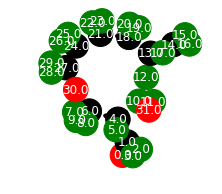

In [5]:
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_directed.html

# node_sizes = [600 + 10 * i for i in range(len(G))]
# M = G.number_of_edges()
# edge_colors = range(2, M + 2)
node_sizes = 600
node_color = {'producer': 'r',
              'consumer': 'g',
              'split': 'k'}

node_colors = [node_color[data['node_type']] for node_id, data in G.nodes(data=True)]
edge_colors = 'k'
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

plotting.draw_network(G, node_sizes=node_sizes, node_colors=node_colors, edge_colors=edge_colors, edge_width=4, figsize=(3,3))

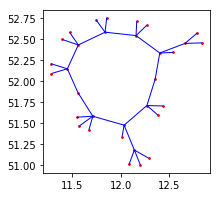

In [6]:
plotting.draw_G(G, 3, 3)

## Project

In [7]:
G.graph = {'crs': {'init': 'epsg:4326'}, 'name': 'fictious_dhn'}

[node for node in G.nodes(data=True)][-1]

(31.0,
 {'lon': 12.3819269720828, 'lat': 51.5937059704184, 'node_type': 'producer'})

3177642345    POINT (24.9278209 60.1677562)
3216400385    POINT (24.9340047 60.1675525)
Name: geometry, dtype: object
{'init': 'epsg:4326'}
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}
3177642345    POINT (385016.9685517756 6671898.076198913)
3216400385    POINT (385359.3161680779 6671864.645833493)
Name: geometry, dtype: object
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}

In [8]:
to_crs = {'datum': 'WGS84',
          'ellps': 'WGS84',
          'proj' : 'utm',
          'zone' : 35,
          'units': 'm'}

G_proj = projections.project_graph(G, to_crs=to_crs)

In [9]:
print(G.graph)
print(G_proj.graph)
G_proj.nodes(data=True)[1]

{'crs': {'init': 'epsg:4326'}, 'name': 'fictious_dhn'}
{'crs': {'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}, 'name': 'fictious_dhn_UTM'}


{'lat': 51.1773061655202,
 'lon': 12.140696651157802,
 'node_type': 'split',
 'x': -536087.5618221961,
 'y': 5775275.894884215}

POINT (384624.1787626689 6671539.986316172)  
{'init': 'epsg:4326'}  
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'zone': 35, 'units': 'm'}

## Convert to geodataframe and save

In [10]:
node_gdf, edge_gdf = input_output.graph_to_gdfs(G_proj)

In [11]:
place_name_out = 'fictios_dhn'
nodes_out = r"shapefiles/%s_nodes.shp" % place_name_out
edges_out = r"shapefiles/%s_edges.shp" % place_name_out

invalid_cols = []
for col in invalid_cols:
    edge_gdf[col] = edge_gdf[col].astype(str)
node_gdf.to_file(edges_out)
edge_gdf.to_file(nodes_out)

/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


# Simulate district heating

## Known consumer flows without loops

In a radial network without loops, pressure does not have to be taken into account at all. The mass flows can be determined given the consumer flows and the continuity equation of flows.

In [12]:
# Create DHN
edge_list = pd.read_csv('data/edge_list_tree_network.csv')
node_list = pd.read_csv('data/node_list_tree_network.csv')
G = input_output.create_network(edge_list, node_list)

In [13]:
# Define consumer flows
m_node = np.array([0.14438711, 0.        , 0.60690656, 0.46021762, 0.        ,
       0.33503917, 0.        , 0.6923997 , 0.23633429, 0.32253777,
       0.28130933, 0.54327004, 0.55097508, 0.        , 0.        ,
       0.98140005, 0.75128985, 0.36809003, 0.        , 0.58412971,
       0.54814071, 0.        , 0.45231742, 0.98044165, 0.        ,
       0.97806519, 0.08478984, 0.        , 0.32523635, 0.39047788,
       -2., -2.])

In [14]:
pipe_flows = simulation.hydraulics_known_flows_wo_loops(G, m_node) 
pipe_flows_v2 = simulation.hydraulics_known_flows_wo_loops_v2(G, m_node) 

print('m_node', m_node)
print('flows', pipe_flows)
print('flows_v2', pipe_flows_v2)

(32,)
(32, 31)
m_node [-6.47336824  0.          0.60690656  0.46021762  0.          0.33503917
  0.          0.6923997   0.23633429  0.32253777  0.28130933  0.54327004
  0.55097508  0.          0.          0.98140005  0.75128985  0.36809003
  0.          0.58412971  0.54814071  0.          0.45231742  0.98044165
  0.          0.97806519  0.08478984  0.          0.32523635  0.39047788
 -2.         -2.        ]
flows [ 6.47336824  0.60690656  0.46021762  5.40624406  0.33503917  1.25127176
  3.81993313  0.6923997   0.23633429  0.32253777  0.54327004  4.99535376
  4.44437868  1.7326899   0.36809003  2.34359875  0.98140005  0.75128985
  0.58412971  0.54814071  1.21132833  0.45231742  0.98044165 -0.22143074
  0.97806519  0.08478984 -1.28428577  0.32523635  0.39047788  2.
  2.        ]
flows_v2 [ 6.47336824  0.60690656  0.46021762  5.40624406  0.33503917  1.25127176
  3.81993313  0.6923997   0.23633429  0.32253777  0.54327004  4.99535376
  4.44437868  1.7326899   0.36809003  2.34359875  0.981

/home/jann/Desktop/repos/models_oemof/DHN_model/module/simulation.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  flows = np.linalg.lstsq(A,m_node)[0]


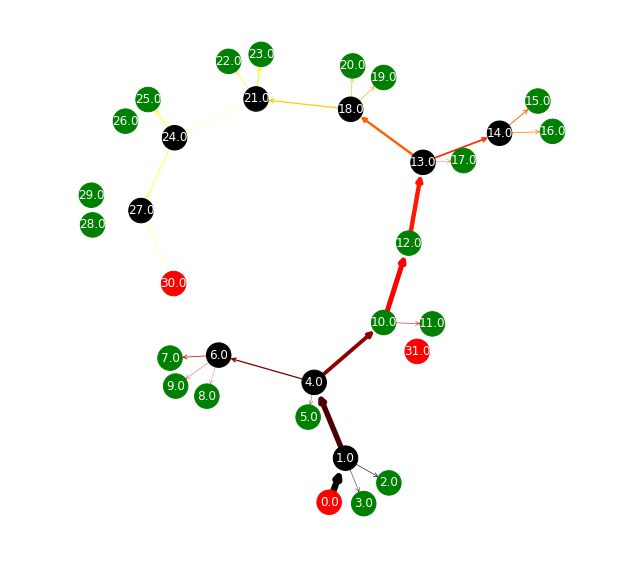

In [15]:
# Need to create a layout when doing
# separate calls to draw nodes and edges
M = G.number_of_edges()
edge_colors = range(2, M + 2)
node_sizes = 600
node_color = {'producer': 'r',
              'consumer': 'g',
              'split': 'k'}

node_colors = [node_color[data['node_type']] for node_id, data in G.nodes(data=True)]

plotting.draw_network(G, node_sizes=node_sizes, node_colors=node_colors,
             edge_colors=edge_colors, edge_width=abs(pipe_flows), figsize=(10,10))

## Known consumer flows with loops

In the case of meshed networks, the number of unknown flows is larger than the number of independent flow continuity equations.

In [16]:
def hydraulics_known_flows_with_loops():
    pass
    

In [17]:
edge_list = pd.read_csv('data/edge_list_loop_network.csv')
node_list = pd.read_csv('data/node_list_loop_network.csv')
G_loop = input_output.create_network(edge_list, node_list)

node_colors = [node_color[data['node_type']] for node_id, data in G_loop.nodes(data=True)]
M = G_loop.number_of_edges()
edge_colors = range(2, M + 2)

In [18]:
number_nodes = len(G_loop.nodes)
m_node = np.array([0.14438711, 0.        , 0.60690656, 0.46021762, 0.        ,
       0.33503917, 0.        , 0.6923997 , 0.23633429, 0.32253777,
       0.28130933])

In [19]:
flows = simulation.hydraulics_known_flows_wo_loops(G_loop, m_node)
flows

(11,)
(11, 11)


array([2.93474444, 0.60690656, 0.46021762, 0.82798959, 1.03963067,
       0.33503917, 0.21164109, 0.28130933, 0.6923997 , 0.23633429,
       0.32253777])

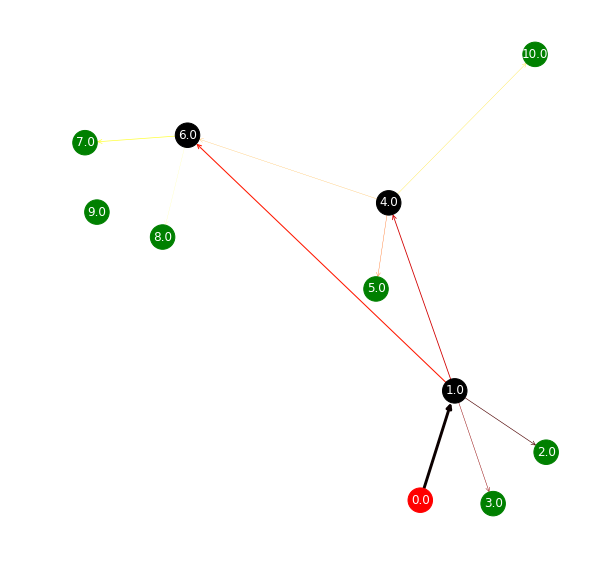

In [20]:
plotting.draw_network(G_loop, node_sizes=node_sizes, node_colors=node_colors,
             edge_colors=edge_colors, edge_width=abs(flows), figsize=(10,10))

## Unknown consumer flows

## Excursion to street networks

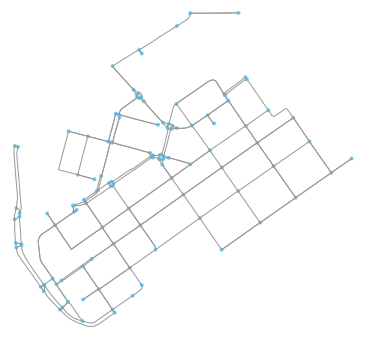

In [21]:
import osmnx as ox
import geopandas as gpd

place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)